In [2]:
# Import necessary libraries

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.callbacks import Callback
import tensorflow_hub as hub
import tensorflow as tf
import re

from keras import backend as K
import keras.layers as layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dropout, Dense, concatenate, Embedding, Flatten, Activation, SpatialDropout1D
from keras.layers import Bidirectional, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import np_utils
from keras.engine import Layer
from keras import initializers, regularizers, constraints
from keras.layers import *

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM, CuDNNGRU, CuDNNLSTM, Add, Reshape
from keras.layers import MaxPooling1D, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from nltk.tokenize import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings('ignore')
import os
#os.environ['OMP_NUM_THREADS'] = '4'

import re
import math
# set seed
np.random.seed(123)

Using TensorFlow backend.
W0411 03:43:00.032337 140311484790144 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


# Read the SNLI dataset

In [4]:
train = pd.read_csv('../input/stanford-natural-language-inference-corpus/snli_1.0_train.csv')
test = pd.read_csv('../input/stanford-natural-language-inference-corpus/snli_1.0_test.csv')
valid = pd.read_csv('../input/stanford-natural-language-inference-corpus/snli_1.0_dev.csv')

In [5]:
print("Training on", train.shape[0], "examples")
print("Validating on", test.shape[0], "examples")
print("Testing on", valid.shape[0], "examples")
#check out the first 10 training records
train[:10]

Training on 550152 examples
Validating on 10000 examples
Testing on 10000 examples


,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN
5,contradiction,( Children ( ( ( smiling and ) waving ) ( at c...,( ( The kids ) ( are frowning ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (DT The) (NNS kids)) (VP (VBP are...,Children smiling and waving at camera,The kids are frowning,2267923837.jpg#2,2267923837.jpg#2r1c,contradiction,NaN,NaN,NaN,NaN
6,contradiction,( ( A boy ) ( ( is ( ( jumping ( on skateboard...,( ( The boy ) ( ( ( skates down ) ( the sidewa...,(ROOT (S (NP (DT A) (NN boy)) (VP (VBZ is) (VP...,(ROOT (S (NP (DT The) (NN boy)) (VP (VBZ skate...,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,3691670743.jpg#0,3691670743.jpg#0r1c,contradiction,NaN,NaN,NaN,NaN
7,entailment,( ( A boy ) ( ( is ( ( jumping ( on skateboard...,( ( The boy ) ( ( does ( a ( skateboarding tri...,(ROOT (S (NP (DT A) (NN boy)) (VP (VBZ is) (VP...,(ROOT (S (NP (DT The) (NN boy)) (VP (VBZ does)...,A boy is jumping on skateboard in the middle o...,The boy does a skateboarding trick.,3691670743.jpg#0,3691670743.jpg#0r1e,entailment,NaN,NaN,NaN,NaN
8,neutral,( ( A boy ) ( ( is ( ( jumping ( on skateboard...,( ( The boy ) ( ( is ( wearing ( safety equipm...,(ROOT (S (NP (DT A) (NN boy)) (VP (VBZ is) (VP...,(ROOT (S (NP (DT The) (NN boy)) (VP (VBZ is) (...,A boy is jumping on skateboard in the middle o...,The boy is wearing safety equipment.,3691670743.jpg#0,3691670743.jpg#0r1n,neutral,NaN,NaN,NaN,NaN
9,neutral,( ( An ( older man ) ) ( ( ( sits ( with ( ( h...,( ( An ( older man ) ) ( ( ( drinks ( his juic...,(ROOT (S (NP (DT An) (JJR older) (NN man)) (VP...,(ROOT (S (NP (DT An) (JJR older) (NN man)) (VP...,An older man sits with his orange juice at a s...,An older man drinks his juice as he waits for ...,4804607632.jpg#0,4804607632.jpg#0r1n,neutral,NaN,NaN,NaN,NaN


In [6]:
#check out missing values
train.isnull().sum()

gold_label                     0
sentence1_binary_parse         0
sentence2_binary_parse         6
sentence1_parse                0
sentence2_parse                0
sentence1                      0
sentence2                      6
captionID                      0
pairID                         0
label1                         0
label2                    510782
label3                    510757
label4                    510769
label5                    513238
dtype: int64

In [7]:
#handle missing values

'''
There are a few NA values to drop in sentence2 and the gold_label has a few "-". 
The "-" values are when the 5 votes from the turk participants came out tied, 
usually caused by very confusingly worded rows, so it is best to remove these as well.

'''

train = train.dropna(subset = ['sentence2'])
train = train[train["gold_label"] != "-"]
test = test[test["gold_label"] != "-"]
valid = valid[valid["gold_label"] != "-"]

In [8]:
#check out unique values in each feature
train.nunique()

gold_label                     3
sentence1_binary_parse    150735
sentence2_binary_parse    479206
sentence1_parse           150735
sentence2_parse           479206
sentence1                 150735
sentence2                 479340
captionID                 151194
pairID                    549361
label1                         3
label2                         3
label3                         3
label4                         3
label5                         3
dtype: int64

# Preprocessing the data



In [9]:
%%time

def get_rnn_data(df):
    x = {
        'sentence1': df["sentence1"],
        'sentence2': df["sentence2"],
        }
    return x

le = LabelEncoder()

X_train = get_rnn_data(train)
Y_train = np_utils.to_categorical(le.fit_transform(train["gold_label"].values)).astype("int64")

X_valid = get_rnn_data(valid)
Y_valid = np_utils.to_categorical(le.fit_transform(valid["gold_label"].values)).astype("int64")

X_test = get_rnn_data(test)
Y_test = np_utils.to_categorical(le.fit_transform(test["gold_label"].values)).astype("int64")

CPU times: user 182 ms, sys: 2.08 ms, total: 184 ms
Wall time: 183 ms


# Create the NLI models based on Custom Layers:

# Model 1: CNN Model with ELMO Embedding

In [11]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)
    
#     def get_config(self):
#         config = {'output_dim': self.output_dim}
    
class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        # do not pass the mask to the next layers   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape
    
#     def get_config(self):
#         config = {'output_dim': self.output_dim}
        
custom_ob={'ElmoEmbeddingLayer': ElmoEmbeddingLayer, 'NonMasking': NonMasking}

In [12]:
def get_model():
    model = Sequential()
    inp1 = Input(shape=(1,), dtype="string", name="sentence1")
    inp2 = Input(shape=(1,), dtype="string", name="sentence2")
    
    def emb_layer(inp, col):
        x = ElmoEmbeddingLayer()(inp)
        return x

    x = concatenate([
                    emb_layer(inp1,"sen_1"),
                    emb_layer(inp2,"sen_2"),
                     ])
    
    x = NonMasking()(x)
    x = Reshape((1, 1024*2), input_shape=(1024*2,))(x)
    
    x = layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(x)
    x = layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(x)
    dropout = layers.Dropout(0.5)(x)
    x = layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(dropout)
    x = layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(x)
    dropout = layers.Dropout(0.5)(x)
    x = layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(dropout)
    x = layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])

    outp = Dense(3, activation="softmax", name="final_output")(x)
    
    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'],
                 )

    return model

model = get_model()

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


W0411 03:44:43.634221 140311484790144 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0411 03:44:44.302001 140311484790144 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0411 03:44:45.553077 140311484790144 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0411 03:44:45.666753 140311484790144 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence1 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
sentence2 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
elmo_embedding_layer_1 (ElmoEmb (None, 1024)         4           sentence1[0][0]                  
__________________________________________________________________________________________________
elmo_embedding_layer_2 (ElmoEmb (None, 1024)         4           sentence2[0][0]                  
__________________________________________________________________________________________________
concatenat

In [13]:
# Create callbacks before starting the training

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
file_path="checkpoint_CNN_SNLI_weights.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
early = EarlyStopping(monitor="val_acc", mode="max", patience=1)

model_callbacks = [checkpoint, early, learning_rate_reduction]

# Train the Model

In [14]:
%%time
 
model.fit(X_train, Y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          callbacks = model_callbacks
         )

Instructions for updating:
Use tf.cast instead.


W0411 03:44:52.453410 140311484790144 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0411 03:44:52.581569 140311484790144 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Train on 549361 samples, validate on 9842 samples
Epoch 1/5
549361/549361 [==============================] - 2050s 4ms/step - loss: 0.8314 - acc: 0.6250 - val_loss: 0.7269 - val_acc: 0.6942

Epoch 00001: val_acc improved from -inf to 0.69417, saving model to checkpoint_CNN_SNLI_weights.hdf5
Epoch 2/5
549361/549361 [==============================] - 2041s 4ms/step - loss: 0.7310 - acc: 0.6873 - val_loss: 0.7157 - val_acc: 0.6981

Epoch 00002: val_acc improved from 0.69417 to 0.69813, saving model to checkpoint_CNN_SNLI_weights.hdf5
Epoch 3/5
549361/549361 [==============================] - 2036s 4ms/step - loss: 0.6970 - acc: 0.7042 - val_loss: 0.6917 - val_acc: 0.7158

Epoch 00003: val_acc improved from 0.69813 to 0.71581, saving model to checkpoint_CNN_SNLI_weights.hdf5
Epoch 4/5
549361/549361 [==============================] - 2037s 4ms/step - loss: 0.6773 - acc: 0.7149 - val_loss: 0.6774 - val_acc: 0.7194

Epoch 00004: val_acc improved from 0.71581 to 0.71937, saving model to checkp

In [15]:
#Save the model
model.save_weights("CNN_SNLI_weights.hdf5")
model.save("CNN_SNLI_model.h5")

# Predictions from the Model and Performing Evaluation 

In [16]:
%%time
test_pred = model.predict(X_test, batch_size=128)

CPU times: user 36 s, sys: 2.43 s, total: 38.4 s
Wall time: 34 s


In [17]:
#convert one hot vector to labels
Y_test = np.argmax(Y_test, axis=1)
Y_test

array([2, 1, 0, ..., 0, 1, 2])

In [18]:
test_acc = (np.argmax(test_pred, axis=1) == Y_test).sum()/Y_test.shape[0] * 100

print("Accuracy on test set is: %"+str(test_acc))

Accuracy on test set is: %73.28990228013029


In [19]:
#convert prediction probabilities to labels
test_pred = np.argmax(test_pred, axis=1)

In [20]:
#Draw Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, test_pred)

array([[2299,  455,  483],
       [ 309, 2595,  464],
       [ 408,  505, 2306]])

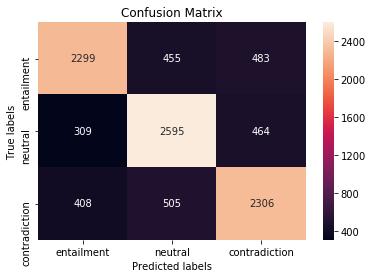

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt     

cm = confusion_matrix(Y_test, test_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['entailment', 'neutral', 'contradiction']); ax.yaxis.set_ticklabels(['entailment', 'neutral', 'contradiction']);

In [22]:
#Make Classification Report
from sklearn.metrics import classification_report
target_names = ['entailment', 'neutral', 'contradiction']
print(classification_report(Y_test, test_pred, target_names=target_names))

               precision    recall  f1-score   support

   entailment       0.76      0.71      0.74      3237
      neutral       0.73      0.77      0.75      3368
contradiction       0.71      0.72      0.71      3219

    micro avg       0.73      0.73      0.73      9824
    macro avg       0.73      0.73      0.73      9824
 weighted avg       0.73      0.73      0.73      9824



# Model 2: LSTM Model with ELMO Embedding

In [11]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)
    
#     def get_config(self):
#         config = {'output_dim': self.output_dim}
    
class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        # do not pass the mask to the next layers   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape
    
#     def get_config(self):
#         config = {'output_dim': self.output_dim}
        
custom_ob={'ElmoEmbeddingLayer': ElmoEmbeddingLayer, 'NonMasking': NonMasking}

In [44]:
def get_model():
    model = Sequential()
    inp1 = Input(shape=(1,), dtype="string", name="sentence1")
    inp2 = Input(shape=(1,), dtype="string", name="sentence2")
    
    def emb_layer(inp, col):
        x = ElmoEmbeddingLayer()(inp)
        return x

    x = concatenate([
                    emb_layer(inp1,"sen_1"),
                    emb_layer(inp2,"sen_2"),
                     ])
    
    x = NonMasking()(x)
    x = Reshape((1, 1024*2), input_shape=(1024*2,))(x)
    x = LSTM(128, return_sequences=True,recurrent_dropout=0.2)(x)
    x = LSTM(128, return_sequences=True,recurrent_dropout=0.2)(x)
    x = LSTM(128, return_sequences=True,recurrent_dropout=0.2)(x)
    x = LSTM(128, return_sequences=True,recurrent_dropout=0.2)(x)
    x = LSTM(128, return_sequences=True,recurrent_dropout=0.2)(x)
    x = LSTM(128, return_sequences=True,recurrent_dropout=0.2)(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])

    outp = Dense(3, activation="softmax", name="final_output")(x)
    
    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'],
                 )

    return model

model = get_model()

model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 20:18:31.767059 140595205010816 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 20:18:33.665425 140595205010816 saver.py:1483] Saver not created because there are no variables in the graph to restore


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence1 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
sentence2 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
elmo_embedding_layer_3 (ElmoEmb (None, 1024)         4           sentence1[0][0]                  
__________________________________________________________________________________________________
elmo_embedding_layer_4 (ElmoEmb (None, 1024)         4           sentence2[0][0]                  
__________________________________________________________________________________________________
concatenat

In [45]:
# Create callbacks before starting the training

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
file_path="checkpoint_LSTM_SNLI_weights.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
early = EarlyStopping(monitor="val_acc", mode="max", patience=1)

model_callbacks = [checkpoint, early, learning_rate_reduction]

In [46]:
%%time
 
history= model.fit(X_train, Y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          callbacks = model_callbacks
         )

Train on 549361 samples, validate on 9842 samples
Epoch 1/5
549361/549361 [==============================] - 2125s 4ms/step - loss: 0.7996 - acc: 0.6403 - val_loss: 0.6892 - val_acc: 0.7078

Epoch 00001: val_acc improved from -inf to 0.70778, saving model to checkpoint_LSTM_SNLI_weights.hdf5
Epoch 2/5
549361/549361 [==============================] - 2110s 4ms/step - loss: 0.6723 - acc: 0.7152 - val_loss: 0.6501 - val_acc: 0.7244

Epoch 00002: val_acc improved from 0.70778 to 0.72445, saving model to checkpoint_LSTM_SNLI_weights.hdf5
Epoch 3/5
549361/549361 [==============================] - 2115s 4ms/step - loss: 0.6301 - acc: 0.7366 - val_loss: 0.6108 - val_acc: 0.7459

Epoch 00003: val_acc improved from 0.72445 to 0.74588, saving model to checkpoint_LSTM_SNLI_weights.hdf5
Epoch 4/5
549361/549361 [==============================] - 2114s 4ms/step - loss: 0.6021 - acc: 0.7504 - val_loss: 0.5985 - val_acc: 0.7521

Epoch 00004: val_acc improved from 0.74588 to 0.75208, saving model to che

In [47]:
#Save the model
model.save_weights("LSTM_SNLI_weights.hdf5")
model.save("LSTM_SNLI_model.h5")

# Predictions from the Model and Performing Evaluation 

In [48]:
%%time
test_pred = model.predict(X_test, batch_size=128)

CPU times: user 39.7 s, sys: 2.36 s, total: 42.1 s
Wall time: 36.9 s


In [ ]:
#convert one hot vector to labels
Y_test = np.argmax(Y_test, axis=1)
Y_test

In [57]:
test_acc = (np.argmax(test_pred, axis=1) == Y_test).sum()/Y_test.shape[0] * 100

print("Accuracy on test set is: %"+str(test_acc))

Accuracy on test set is: %74.94910423452768


In [58]:
#convert prediction probabilities to labels
test_pred = np.argmax(test_pred, axis=1)

In [59]:
#Draw Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, test_pred)

array([[2499,  378,  360],
       [ 357, 2650,  361],
       [ 509,  496, 2214]])

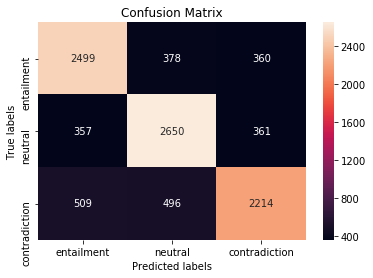

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt     

cm = confusion_matrix(Y_test, test_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['entailment', 'neutral', 'contradiction']); ax.yaxis.set_ticklabels(['entailment', 'neutral', 'contradiction']);

In [61]:
#Make Classification Report
from sklearn.metrics import classification_report
target_names = ['entailment', 'neutral', 'contradiction']
print(classification_report(Y_test, test_pred, target_names=target_names))

               precision    recall  f1-score   support

   entailment       0.74      0.77      0.76      3237
      neutral       0.75      0.79      0.77      3368
contradiction       0.75      0.69      0.72      3219

    micro avg       0.75      0.75      0.75      9824
    macro avg       0.75      0.75      0.75      9824
 weighted avg       0.75      0.75      0.75      9824



# Model 3: Bidirectional LSTM Model with ELMO Embedding

In [11]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)
    
#     def get_config(self):
#         config = {'output_dim': self.output_dim}
    
class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        # do not pass the mask to the next layers   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape
    
#     def get_config(self):
#         config = {'output_dim': self.output_dim}
        
custom_ob={'ElmoEmbeddingLayer': ElmoEmbeddingLayer, 'NonMasking': NonMasking}

In [9]:
def get_model():
    model = Sequential()
    inp1 = Input(shape=(1,), dtype="string", name="sentence1")
    inp2 = Input(shape=(1,), dtype="string", name="sentence2")
    
    def emb_layer(inp, col):
        x = ElmoEmbeddingLayer()(inp)
        return x

    x = concatenate([
                    emb_layer(inp1,"sen_1"),
                    emb_layer(inp2,"sen_2"),
                     ])
    
    x = NonMasking()(x)
    x = Reshape((1, 1024*2), input_shape=(1024*2,))(x)
    x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
    x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
    x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
    x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
    x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
    x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])

    outp = Dense(3, activation="softmax", name="final_output")(x)
    
    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'],
                 )

    return model

model = get_model()

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


W0410 16:37:16.560651 140595205010816 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:37:17.243333 140595205010816 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 16:37:18.595419 140595205010816 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0410 16:37:19.239344 140595205010816 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence1 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
sentence2 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
elmo_embedding_layer_1 (ElmoEmb (None, 1024)         4           sentence1[0][0]                  
__________________________________________________________________________________________________
elmo_embedding_layer_2 (ElmoEmb (None, 1024)         4           sentence2[0][0]                  
__________________________________________________________________________________________________
concatenat

In [10]:
# Create callbacks before starting the training

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
file_path="checkpoint_SNLI_weights.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
early = EarlyStopping(monitor="val_acc", mode="max", patience=1)

model_callbacks = [checkpoint, early, learning_rate_reduction]

# Train the Model

In [11]:
%%time
 
model.fit(X_train, Y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          callbacks = model_callbacks
         )

Instructions for updating:
Use tf.cast instead.


W0410 16:37:23.403832 140595205010816 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0410 16:37:23.531294 140595205010816 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Train on 549361 samples, validate on 9842 samples
Epoch 1/5
549361/549361 [==============================] - 2193s 4ms/step - loss: 0.7656 - acc: 0.6608 - val_loss: 0.6640 - val_acc: 0.7164

Epoch 00001: val_acc improved from -inf to 0.71642, saving model to checkpoint_SNLI_weights.hdf5
Epoch 2/5
549361/549361 [==============================] - 2169s 4ms/step - loss: 0.6530 - acc: 0.7248 - val_loss: 0.6245 - val_acc: 0.7394

Epoch 00002: val_acc improved from 0.71642 to 0.73938, saving model to checkpoint_SNLI_weights.hdf5
Epoch 3/5
549361/549361 [==============================] - 2171s 4ms/step - loss: 0.6106 - acc: 0.7464 - val_loss: 0.6007 - val_acc: 0.7503

Epoch 00003: val_acc improved from 0.73938 to 0.75025, saving model to checkpoint_SNLI_weights.hdf5
Epoch 4/5
549361/549361 [==============================] - 2171s 4ms/step - loss: 0.5784 - acc: 0.7618 - val_loss: 0.5927 - val_acc: 0.7585

Epoch 00004: val_acc improved from 0.75025 to 0.75848, saving model to checkpoint_SNLI_we

In [12]:
#Save the model
model.save_weights("SNLI_weights.hdf5")
model.save("SNLI_model.h5")

# Predictions from the Model and Performing Evaluation 

In [13]:
%%time
test_pred = model.predict(X_test, batch_size=128)

CPU times: user 38.6 s, sys: 2.56 s, total: 41.2 s
Wall time: 36.5 s


In [14]:
test_acc = (np.argmax(test_pred, axis=1) == np.argmax(Y_test, axis=1)).sum()/Y_test.shape[0] * 100

print("Accuracy on test set is: %"+str(test_acc))

Accuracy on test set is: %75.68200325732899


In [22]:
#convert one hot vector to labels
Y_test = np.argmax(Y_test, axis=1)
Y_test

array([2, 1, 0, ..., 0, 1, 2])

In [17]:
#convert prediction probabilities to labels
test_pred = np.argmax(test_pred, axis=1)

In [23]:
#Draw Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, test_pred)

array([[2313,  421,  503],
       [ 263, 2727,  378],
       [ 329,  495, 2395]])

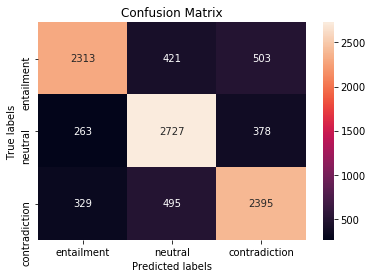

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt     

cm = confusion_matrix(Y_test, test_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['entailment', 'neutral', 'contradiction']); ax.yaxis.set_ticklabels(['entailment', 'neutral', 'contradiction']);

In [25]:
#Make Classification Report
from sklearn.metrics import classification_report
target_names = ['entailment', 'neutral', 'contradiction']
print(classification_report(Y_test, test_pred, target_names=target_names))

               precision    recall  f1-score   support

   entailment       0.80      0.71      0.75      3237
      neutral       0.75      0.81      0.78      3368
contradiction       0.73      0.74      0.74      3219

    micro avg       0.76      0.76      0.76      9824
    macro avg       0.76      0.76      0.76      9824
 weighted avg       0.76      0.76      0.76      9824

